In [1]:
import networkx as nx
import numpy as np
import cv2
import re
import utils
import tensorflow as tf
import keras
import tempNet
import time


from sklearn import feature_extraction
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


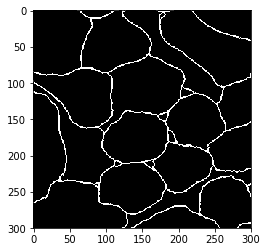

In [2]:
num_images = 10

tl = (200, 275)
height = 300
width = 300

images = []
ground_truths = []

for x in range(num_images):
    img = cv2.imread('data/slice_0/O', 0)
    gt = cv2.imread('data/slice_0/G', 0)
    img = utils.crop_2d(img, tl, height, width)
    gt = utils.crop_2d(gt, tl, height, width)
    images.append(img)
    ground_truths.append(gt)

img = images[0]
gt = ground_truths[0]

plt.imshow(img, cmap='gray')
plt.imshow(gt, cmap='gray')

In [3]:
gt_cuts = utils.generate_gt_cuts(gt)

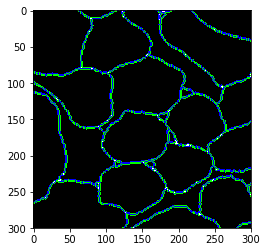

In [4]:
utils.view_boundaries(gt, gt_cuts)

# Import seeds

In [5]:
seeds = []
f = open("data/slice_0/seeds.txt", 'r')
for line in f:
    y = int(float(re.split(' ', line)[0]))
    x = int(float(re.split(' ', line)[1]))
    seed = (x, y)

    if x >= tl[0] and x <= tl[0] + width:
        if y >= tl[1] and y <= tl[1] + height:
            x = x - tl[0]
            y = y - tl[1]
            seed = (x, y)
            seeds.append(seed)

In [6]:
a = gt.copy()
a = cv2.cvtColor(a,cv2.COLOR_GRAY2RGB)
for x, y in seeds:
    a[x-1, y-1] = [255,0,0]

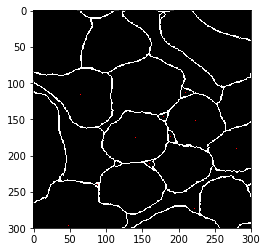

In [7]:
plt.imshow(a)

In [8]:
boundary_probabilities = np.random.randn(*img.shape)
I_a = np.stack((img, boundary_probabilities), axis=2)
I_a = np.expand_dims(I_a, 0)

images_in = utils.prepare_input_images(I_a[0])

In [9]:
# Create graph
graph = utils.img_to_graph(img)

# Generate Shortest Paths

In [ ]:
t_net = tempNet.TempNet()
image_placeholder = tf.placeholder(tf.float32,
                                   shape=(None, 15, 15, 2))
t_net.build(image_placeholder)

sess = tf.Session()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

Build model started.
Build model finished: 3.896417s


In [ ]:
with sess.as_default():
    
    # Restore variables from disk.
    saver.restore(sess, "saved_model/model.ckpt")
    print("Model restored.")
    #sess.run(tf.global_variables_initializer())
    
    # For number of epochs
    for epoch in range(100):
        
        print "\n=========="
        print "Epoch ", epoch + 1
        print "==========\n"
        
        # Compute altitudes.
        altitude_dict = t_net.predict_edges(images_in, sess, 1000)
        
        loss_dict = {}

        for u, v in graph.edges_iter():
            graph.edge[u][v]['weight'] = altitude_dict[v]
            loss_dict[(u, v)] = [images_in[v], altitude_dict[v]]

        # Compute the cut edges and the shortest paths. 
        graph = utils.prims_initialize(graph)
        cuts, paths = utils.gradient_segmentation(graph, seeds)

        for edge in gt_cuts:
            graph.edge[edge[0]][edge[1]]['weight'] = np.inf

        # Compute the ground truth paths.
        graph = utils.prims_initialize(graph)
        constrained_cuts, gt_paths = utils.gradient_segmentation(graph, seeds)

        # Find root error edges and the number of children for each.
        children = utils.compute_root_error_edge_children(paths, gt_paths, cuts, gt_cuts)

        images = []
        weights = []

        for edge in children:
            try:
                images.append(loss_dict[edge][0])
                weights.append(children[edge])
            except KeyError:
                weights.append(children[edge])
                edge = tuple(reversed(edge))
                images.append(loss_dict[edge][0])

        batches = utils.create_batches(np.array(images), np.array(weights))

        loss = 0

        for k, v in children.iteritems():
            try:
                loss += loss_dict[k][1] * v
            except KeyError:
                k = tuple(reversed(k))
                loss += loss_dict[k][1] * v

        print "Loss: ", loss

        # Zero out gradient accumulator.
        sess.run(t_net.zero_ops)

        # Accumulate gradients.
        for batch in batches:
            sess.run(t_net.accum_ops, feed_dict={image_placeholder: batch[0],
                                           t_net.gradient_weights: [batch[1]],
                                           keras.backend.learning_phase(): 0})

        sess.run(t_net.train_step)
        
        save_path = saver.save(sess, "saved_model/model.ckpt")
        print("Model saved in file: %s" % save_path)

INFO:tensorflow:Restoring parameters from saved_model/model.ckpt
Model restored.

Epoch  1

Starting predictions
Prediction Done.  Average time: 0.223433s, Total time: 20.108954s
Starting gradient segmentation...
Segmentation done: 905.300014s
Calculating Cuts...
Done: 0.762951s
Starting gradient segmentation...


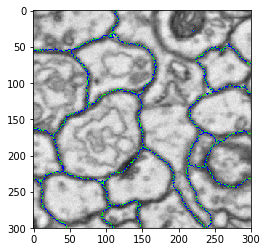

In [17]:
utils.view_boundaries(img, cuts)